In [1]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as tt

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This notebook shows how to do hierarchical modelling with Binomially-distributed random variables.

# Problem Setup

Baseball players have many metrics measured for them. Let's say we are on a baseball team, and would like to quantify player performance, one metric being their batting average (defined by how many times a batter hit a pitched ball, divided by the number of times they were up for batting ("at bat")). How would you go about this task?

We first need some measurements of batting data. To answer this question, we need to have data on the number of time a player has batted and the number of times the player has hit the ball while batting. Let's see an example dataset below.

In [2]:
df = pd.read_csv("../datasets/baseballdb/core/Batting.csv")
df["AB"] = df["AB"].replace(0, np.nan)
df = df.dropna()
df["batting_avg"] = df["H"] / df["AB"]
df = df[df["yearID"] >= 2016]
df = df.iloc[
    0:15
]  # select out only the first 15 players, just for illustration purposes.
df.head(5)

playerID  yearID  stint teamID lgID    G     AB   R    H  2B  \
101333   abadfe01    2016      1    MIN   AL   39    1.0   0    0   0   
101335  abreujo02    2016      1    CHA   AL  159  624.0  67  183  32   
101337  ackledu01    2016      1    NYA   AL   28   61.0   6    9   0   
101338  adamecr01    2016      1    COL   NL  121  225.0  25   49   7   
101340  adamsma01    2016      1    SLN   NL  118  297.0  37   74  18   

           ...        SB   CS  BB     SO  IBB   HBP   SH   SF  GIDP  \
101333     ...       0.0  0.0   0    1.0  0.0   0.0  0.0  0.0   0.0   
101335     ...       0.0  2.0  47  125.0  7.0  15.0  0.0  9.0  21.0   
101337     ...       0.0  0.0   8    9.0  0.0   0.0  0.0  1.0   0.0   
101338     ...       2.0  3.0  24   47.0  0.0   4.0  3.0  0.0   5.0   
101340     ...       0.0  1.0  25   81.0  1.0   2.0  0.0  3.0   5.0   

        batting_avg  
101333     0.000000  
101335     0.293269  
101337     0.147541  
101338     0.217778  
101340     0.249158  

[5 rows x 23 columns]

In this dataset, the columns `AB` and `H` are the most relevent.

- `AB` is the number of times a player was **A**t **B**at.
- `H` is the number of times a player **h**it the ball while batting.

The performance of a player can be defined by their batting percentage - essentially the number of hits divided by the number of times at bat. (Technically, a percentage should run from 0-100, but American sportspeople are apparently not very strict with how they approach these definitions.)

# Model 1: Naive Model

One model that we can write is a model that assumes that each player has a batting percentage that is independent of the other players in the dataset. 

A pictorial view of the model is as such:

![](../images/baseball-model.jpg)

Let's implement this model in PyMC3.

In [3]:
with pm.Model() as baseline_model:
    thetas = pm.Beta("thetas", alpha=0.5, beta=0.5, shape=(len(df)))
    like = pm.Binomial("likelihood", n=df["AB"], p=thetas, observed=df["H"])

In [4]:
with baseline_model:
    baseline_trace = pm.sample(2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [thetas_logodds__]
100%|██████████| 2500/2500 [00:03<00:00, 681.21it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Let's view the posterior distribution traces.

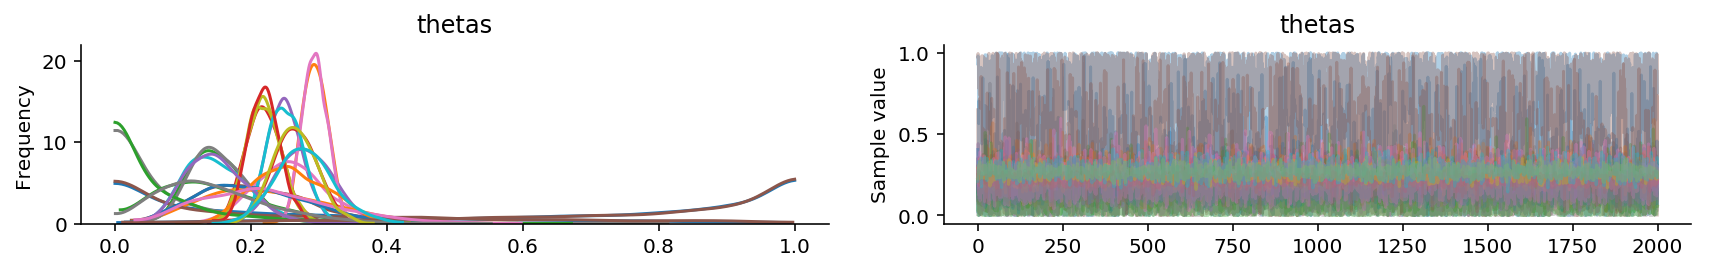

In [5]:
traceplot = pm.traceplot(baseline_trace)

Looks like convergence has been achieved. From a $Beta(\alpha=0.5, \beta=0.5)$ prior, those players for which we have only 1 data point have very wide posterior distribution estimates.

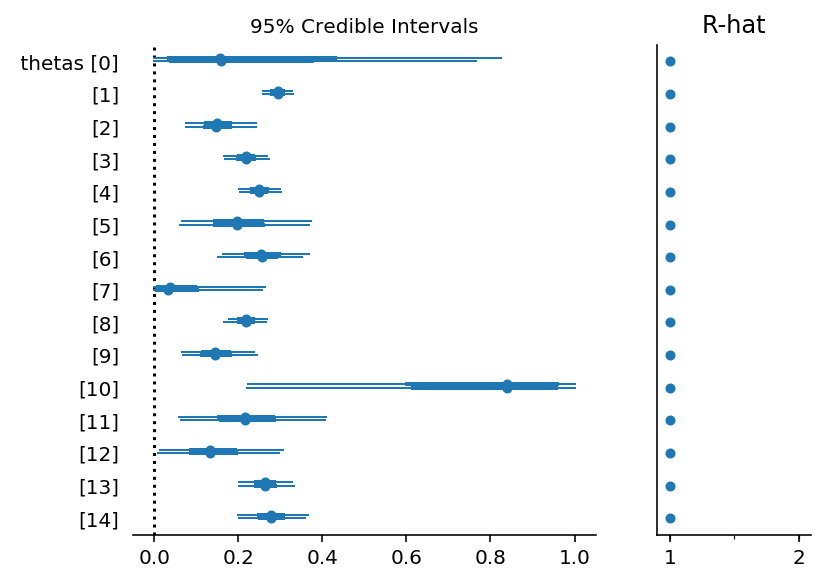

In [9]:
pm.forestplot(baseline_trace)

One of the big problems that we may have observed above is that the posterior distribution estimates for some players look very "absurd", raising a number of questions. For example:

- Do we really expect the 1 bat, 1 hit player to have such a high estimated batting average?
- Do we really expect the 1 bat, 0 hits player to have such a low estimated batting average?
- Don't we usually expect human performance to be approximately symmetrically distributed around some population mean?

# Model 2: Hierarchical Model

With a hierarchical model, we can encode a set of assumptions into the model that may help us address the above questions. By a hierarchical model, we mean that each group's key parameter (in this case, the ${\theta}$) have a parental distribution placed on top of them. This is sometimes anthropomorphically called "sharing information" between the distributions. (Not saying that this is a good or bad thing, just naming it as it is.)

The model diagram looks something like this:

![](../images/baseball-hierarchical-model.jpg)

Let's start by specifying the model.

In [10]:
with pm.Model() as baseball_model:

    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    thetas = pm.Beta(
        "thetas", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=len(df)
    )
    like = pm.Binomial("like", n=df["AB"], p=thetas, observed=df["H"])

Then we sample from the posterior.

In [13]:
with baseball_model:
    trace = pm.sample(2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [thetas_logodds__, kappa_log_log__, phi_interval__]
100%|██████████| 2500/2500 [00:07<00:00, 336.01it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Finally, let's inspect the traces for convergence.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20d64a58>,
      dtype=object)

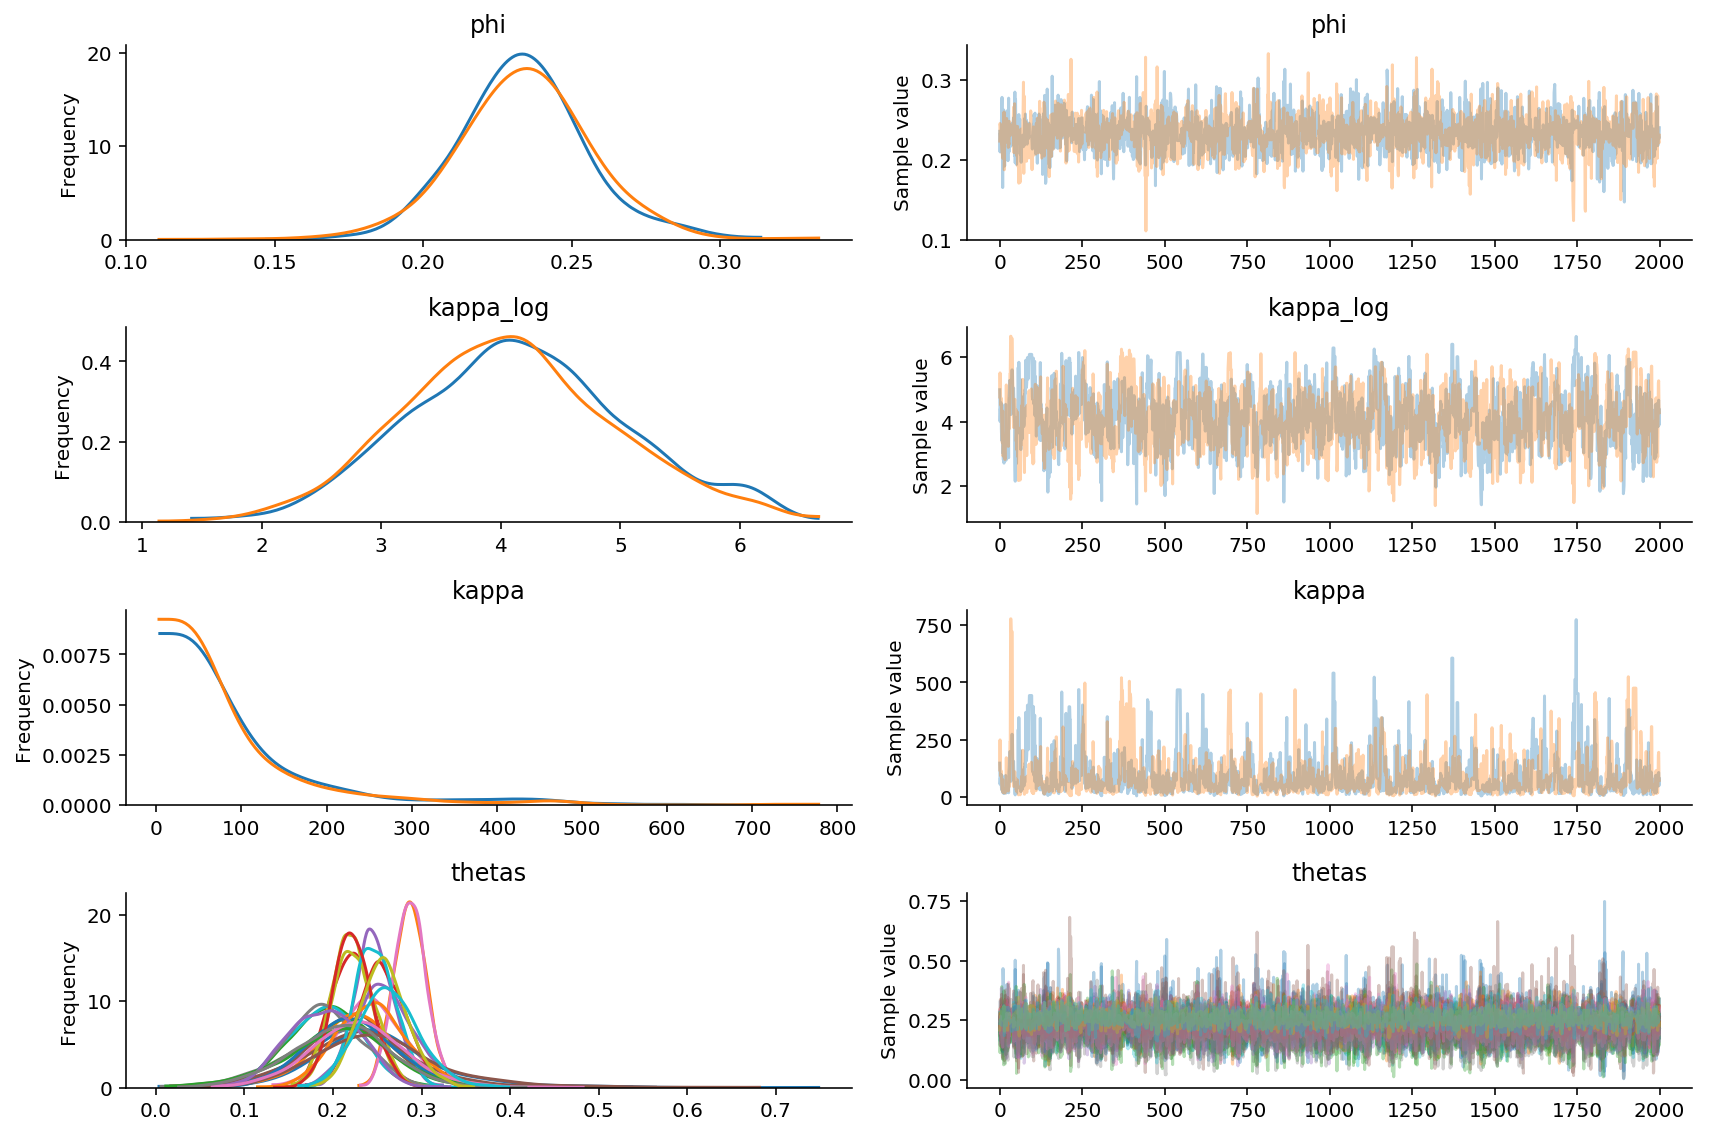

In [14]:
pm.traceplot(trace)

Convergence looks good! Let's also look at the posterior distribution of batting averages per player.

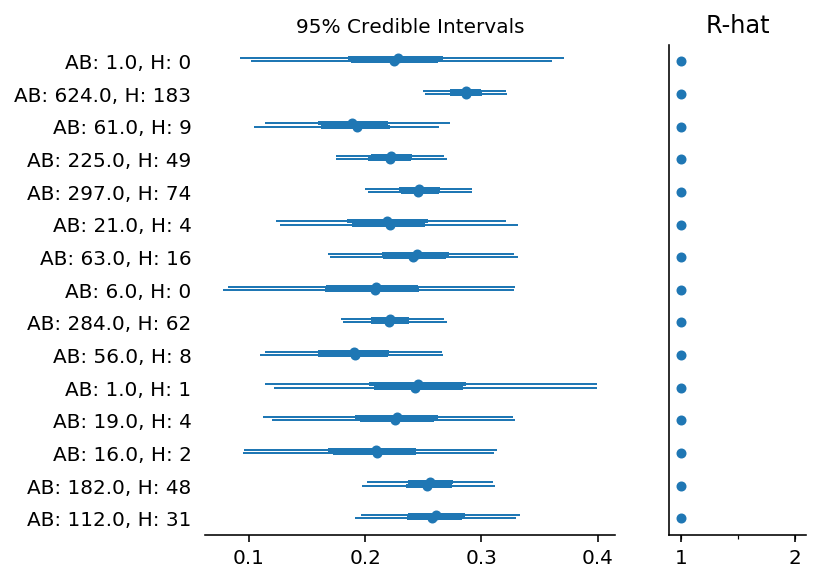

In [15]:
ylabels = "AB: " + df["AB"].astype(str) + ", H: " + df["H"].astype("str")
pm.forestplot(trace, varnames=["thetas"], ylabels=ylabels)

It appears to me that these estimates are going to be much more reasonable. No player has a wildly high or low estimate on the basis of a single (or very few) data points.

With a hierarchical model, we make the assumption that our observations (or treatments that group our observations) are somehow related. Under this assumption, when we have a new sample for which we have very few observations, we are able to borrow power from the population to make inferences about the new sample.

Depending on the scenario, this assumption can either be reasonable, thereby not necessitating much debate, or be considered a "strong assumption", thereby requiring strong justification.

## Shrinkage

"Shrinkage" is a term used to describe how hierarchical model estimation will usually result in parameter estimates that are "shrunk" away from their maximum likelihood estimators (i.e. the naive estimate from the data) towards the global mean.

Shrinkage in and of itself is not necessarily a good or bad thing. However, because hierarchical models can sometimes be tricky to get right, we can use a shrinkage plot as a visual diagnostic for whether we have implemented the model correctly.

array([0.24915534, 0.29389386, 0.153109  , 0.21888468, 0.25013017,
       0.20448923, 0.25813361, 0.07028544, 0.21911462, 0.14926427,
       0.75117488, 0.22586705, 0.14692702, 0.26454521, 0.27914024])

(0, 1)

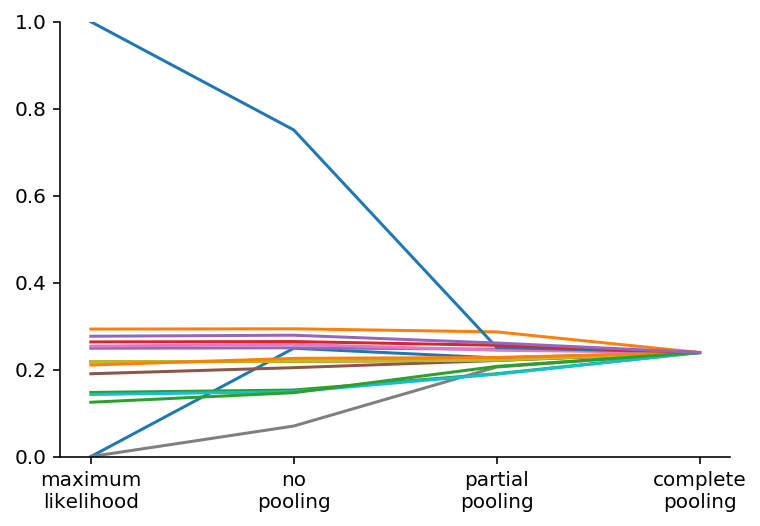

In [25]:
# MLE per player
mle = df["batting_avg"].values
# Non-hierarchical model
no_pool = baseline_trace["thetas"].mean(axis=0)
# Hierarchical model
partial_pool = trace["thetas"].mean(axis=0)
# MLE over all players
complete_pool = np.array([df["batting_avg"].mean()] * len(df))

fig = plt.figure()
ax = fig.add_subplot(111)

for r in np.vstack([mle, no_pool, partial_pool, complete_pool]).T:
    ax.plot(r)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(
    ["maximum\nlikelihood", "no\npooling", "partial\npooling", "complete\npooling"]
)
ax.set_ylim(0, 1)

In this shrinkage plot, as we go from the maximum likelihood estimator (MLE) (essentially not explicitly specifying priors) to a no-pooling model (with weak priors), there is "shrinkage" of the estimates towards the population mean (complete pooling). Incorporating a parental prior on each group's parameters further constrains the credible range of parameters. This, then, is the phenomenon of "shrinkage" in modelling.

Just to reiterate again -- there is nothing ineherently right or wrong about shrinkage. Whether this is reasonable or not depends on our prior information about the problem.